### Passo 1: Configurar a API do Kaggle

Como este é um novo ambiente no Colab, o primeiro passo é nos autenticarmos no Kaggle para baixar os dados. Esta célula irá pedir que você faça o upload do seu arquivo `kaggle.json`.

(Você pode obter este arquivo na seção "API" da sua conta no Kaggle.)

In [ ]:
# Célula 1: Fazer upload do seu kaggle.json
from google.colab import files
import os

print("Por favor, faça o upload do seu arquivo kaggle.json")
files.upload()

# Move o arquivo para o diretório correto e ajusta permissões
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Por favor, faça o upload do seu arquivo kaggle.json


Saving kaggle.json to kaggle.json


### Passo 2: Baixar e Descompactar o Dataset

Com a API configurada, agora podemos baixar o dataset e descompactá-lo no ambiente do Colab. Após esta célula ser executada, a pasta `processed_data` estará pronta para ser usada.

In [ ]:
# Célula 2: Baixar o dataset do Kaggle
!kaggle datasets download -d fahadullaha/facial-emotion-recognition-dataset

# Descompactar os dados e remover o arquivo .zip
!unzip -q facial-emotion-recognition-dataset.zip
!rm facial-emotion-recognition-dataset.zip

print("Dataset baixado e descompactado com sucesso!")

Dataset URL: https://www.kaggle.com/datasets/fahadullaha/facial-emotion-recognition-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
 74% 148M/200M [00:00<00:00, 1.55GB/s]
100% 200M/200M [00:00<00:00, 1.18GB/s]
Dataset baixado e descompactado com sucesso!


### Passo 3: Configuração e Imports

Agora que os dados estão no lugar, importamos todas as bibliotecas que vamos precisar para o pré-processamento, a construção do modelo e o treinamento.

In [ ]:
# Célula 3: Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

### Passo 4: Carregar os Caminhos das Imagens e Dividir os Dados

Com os arquivos disponíveis, vamos ler os caminhos de todas as imagens e seus respectivos rótulos (emoções). Em seguida, usaremos a função `train_test_split` para dividir nosso dataset em 80% para treino e 20% para validação, garantindo que a proporção de cada emoção seja mantida em ambas as divisões (`stratify`).

In [ ]:
# Célula 4: Carregar caminhos e criar a divisão Treino/Validação
base_dir = 'processed_data'

# Criar listas para os caminhos e labels
filepaths = []
labels = []

folds = os.listdir(base_dir)
for fold in folds:
    foldpath = os.path.join(base_dir, fold)
    if not os.path.isdir(foldpath):
        continue

    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Criar um DataFrame a partir das listas
df = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Dividir o DataFrame em treino e validação
train_df, valid_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42, stratify=df['label'])

print('Dados de Treino:')
print(train_df['label'].value_counts())
print('\nDados de Validação:')
print(valid_df['label'].value_counts())

Dados de Treino:
label
happy       9118
neutral     6533
sad         5228
fear        4736
angry       4736
disgust     4736
surprise    4736
Name: count, dtype: int64

Dados de Validação:
label
happy       2280
neutral     1633
sad         1307
angry       1184
disgust     1184
fear        1184
surprise    1184
Name: count, dtype: int64


### Passo 5: Criar Geradores de Imagens (com Data Augmentation)

Agora que temos nossos DataFrames de treino e validação, vamos criar os geradores de dados. O `ImageDataGenerator` do Keras é uma ferramenta poderosa que faz duas coisas importantes:
1.  **Carrega as imagens em lotes (batches)** diretamente do disco, o que economiza muita memória RAM.
2.  **Aplica Data Augmentation em tempo real** no conjunto de treino. Isso significa que a cada época, o modelo verá versões ligeiramente diferentes das mesmas imagens (com rotação, zoom, etc.), o que o ajuda a generalizar melhor e reduz o overfitting.

**Importante:** A augmentation é aplicada apenas nos dados de treino. Nos dados de validação, apenas normalizamos os pixels (`rescale`), pois queremos avaliar o modelo em imagens originais, não modificadas.

In [ ]:
# Célula 5: Criar ImageDataGenerators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Definir parâmetros
IMG_SIZE = (48, 48)
BATCH_SIZE = 64

# Criar os geradores usando os DataFrames
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False # importante para a avaliação
)

Found 39823 validated image filenames belonging to 7 classes.
Found 9956 validated image filenames belonging to 7 classes.


### Passo 6: Calcular Pesos de Classe para Lidar com o Desbalanceamento

Este é um passo crucial para resolver o problema que identificamos no Notebook 1. Vamos calcular "pesos" para cada classe de emoção. As classes com menos imagens (como "disgust") receberão um peso maior, e as classes com mais imagens (como "happy") receberão um peso menor. Ao passar esses pesos para o modelo durante o treinamento, estamos dizendo a ele: "Preste mais atenção aos erros que você comete nas classes com menos exemplos". Isso força o modelo a aprender as características das classes minoritárias com mais cuidado.

In [ ]:
# Célula 6: Calcular os pesos de classe
from sklearn.utils import class_weight
import numpy as np

# As classes são ordenadas alfabeticamente pelo flow_from_dataframe
class_labels = sorted(train_df['label'].unique())

# Calcula os pesos
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)

# Cria um dicionário mapeando o índice da classe ao seu peso
class_weights = {i : class_weights_array[i] for i, label in enumerate(class_labels)}


print("Classes ordenadas:", class_labels)
print("Pesos calculados:", class_weights)

Classes ordenadas: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Pesos calculados: {0: np.float64(1.201224662162162), 1: np.float64(1.201224662162162), 2: np.float64(1.201224662162162), 3: np.float64(0.6239306865540689), 4: np.float64(0.8708097351905709), 5: np.float64(1.0881790359602141), 6: np.float64(1.201224662162162)}


### Passo 7: Construir a Arquitetura do Modelo (CNN)

Finalmente, vamos projetar nossa Rede Neural Convolucional. A arquitetura a seguir é um bom ponto de partida:
* **Blocos Convolucionais:** Consistem em uma camada `Conv2D` (para extrair características como bordas e texturas), uma camada `BatchNormalization` (para estabilizar o treinamento), uma `MaxPooling2D` (para reduzir a dimensão da imagem e focar nas características mais importantes) e um `Dropout` (para prevenir que o modelo memorize os dados de treino). Repetimos essa estrutura algumas vezes para aprender características cada vez mais complexas.
* **Camadas Finais:** Uma camada `Flatten` para transformar os mapas de características 2D em um vetor 1D, seguida por camadas `Dense` (totalmente conectadas) para realizar a classificação final. A última camada usa a ativação `softmax` para nos dar a probabilidade de a imagem pertencer a cada uma das 7 emoções.

In [ ]:
# Célula 7: Construir o modelo CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential([
    # Input Block
    Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),

    # Block 2
    Conv2D(64, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),

    # Block 3
    Conv2D(128, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.4),

    # Flatten and Dense Layers
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(7, activation='softmax') # 7 classes de emoções
])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,935 (2.61 MB)

 Trainable params: 684,231 (2.61 MB)

 Non-trainable params: 704 (2.75 KB)

### Passo 8: Compilar o Modelo

Antes de treinar, precisamos "compilar" o modelo. Este passo configura o processo de aprendizado. Nós definimos três coisas principais:
1.  **Otimizador (`optimizer`):** O algoritmo que ajusta os pesos da rede para minimizar o erro. `Adam` é uma escolha robusta e muito popular que funciona bem na maioria dos casos.
2.  **Função de Perda (`loss`):** A métrica que o otimizador tentará minimizar. Como temos mais de duas classes de emoções, usamos a `categorical_crossentropy`.
3.  **Métricas (`metrics`):** As métricas que usamos para monitorar o desempenho do modelo durante o treinamento. A mais comum é a `accuracy` (acurácia).

In [ ]:
# Célula 8: Compilar o modelo
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Passo 9: Treinar o Modelo

Este é o momento da verdade! Vamos chamar a função `model.fit()` para iniciar o treinamento. Aqui, nós passamos:
* Os **geradores de treino e validação** que criamos.
* O número de **épocas (`epochs`)**, que é o número de vezes que o modelo verá o conjunto de dados de treino completo.
* Os **pesos de classe (`class_weight`)** que calculamos para forçar o modelo a prestar mais atenção nas emoções com menos amostras.
* **Callbacks:** Funções especiais que monitoram o treinamento. Usaremos duas muito úteis:
    * `EarlyStopping`: Para o treinamento automaticamente se a performance na validação não melhorar por um número definido de épocas (paciência), evitando overfitting.
    * `ReduceLROnPlateau`: Reduz a taxa de aprendizado se o treinamento estagnar, ajudando o modelo a encontrar um mínimo de erro melhor.

O treinamento pode demorar um pouco, dependendo da GPU do Colab. 🚀

In [ ]:
# Célula 9: Treinar o modelo
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Definindo os callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    verbose=1
)

# Iniciando o treinamento
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_df) // BATCH_SIZE,
    epochs=300,  # Um número alto, mas o EarlyStopping provavelmente vai parar antes
    validation_data=valid_generator,
    validation_steps=len(valid_df) // BATCH_SIZE,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/300
622/622 ━━━━━━━━━━━━━━━━━━━━ 53s 85ms/step - accuracy: 0.2087 - loss: 2.3402 - val_accuracy: 0.1986 - val_loss: 2.0116 - learning_rate: 0.0010
Epoch 2/300
  1/622 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.2656 - loss: 1.6904

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


622/622 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.2656 - loss: 1.6904 - val_accuracy: 0.2778 - val_loss: 1.8503 - learning_rate: 0.0010
Epoch 3/300
622/622 ━━━━━━━━━━━━━━━━━━━━ 43s 70ms/step - accuracy: 0.3187 - loss: 1.7294 - val_accuracy: 0.3966 - val_loss: 1.5530 - learning_rate: 0.0010
Epoch 4/300
622/622 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.3750 - loss: 1.8507 - val_accuracy: 0.3999 - val_loss: 1.5583 - learning_rate: 0.0010
Epoch 5/300
622/622 ━━━━━━━━━━━━━━━━━━━━ 44s 71ms/step - accuracy: 0.3639 - loss: 1.6426 - val_accuracy: 0.4032 - val_loss: 1.5263 - learning_rate: 0.0010
Epoch 6/300
622/622 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.3594 - loss: 1.6097 - val_accuracy: 0.4221 - val_loss: 1.4910 - learning_rate: 0.0010
Epoch 7/300
622/622 ━━━━━━━━━━━━━━━━━━━━ 43s 69ms/step - accuracy: 0.3969 - loss: 1.5704 - val_accuracy: 0.4713 - val_loss: 1.4064 - learning_rate: 0.0010
Epoch 8/300
622/622 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.4531 - loss: 1.4124 -

### Passo 10: Avaliar o Treinamento e Salvar os Resultados

Após o treinamento, o último passo é avaliar a performance do modelo e salvar tudo o que precisamos para uso futuro. Faremos três coisas:

1.  **Visualizar as Curvas de Treinamento:** Plotaremos gráficos da acurácia e da perda (loss) ao longo das épocas. Isso nos ajuda a diagnosticar visualmente se o modelo aprendeu bem e se houve overfitting (quando a performance no treino melhora, mas na validação piora).
2.  **Salvar os Pesos do Modelo:** Salvaremos o modelo treinado em um arquivo (`.keras`). Este arquivo contém a arquitetura e os pesos aprendidos, pronto para ser carregado e usado para fazer previsões.
3.  **Salvar o Sumário em JSON:** Criaremos um dicionário com todos os dados (histórico de acurácia/loss, mapeamento de classes, parâmetros) e o salvaremos como um arquivo `.json`. Este arquivo será perfeito para o front-end consumir e exibir as informações do treinamento.

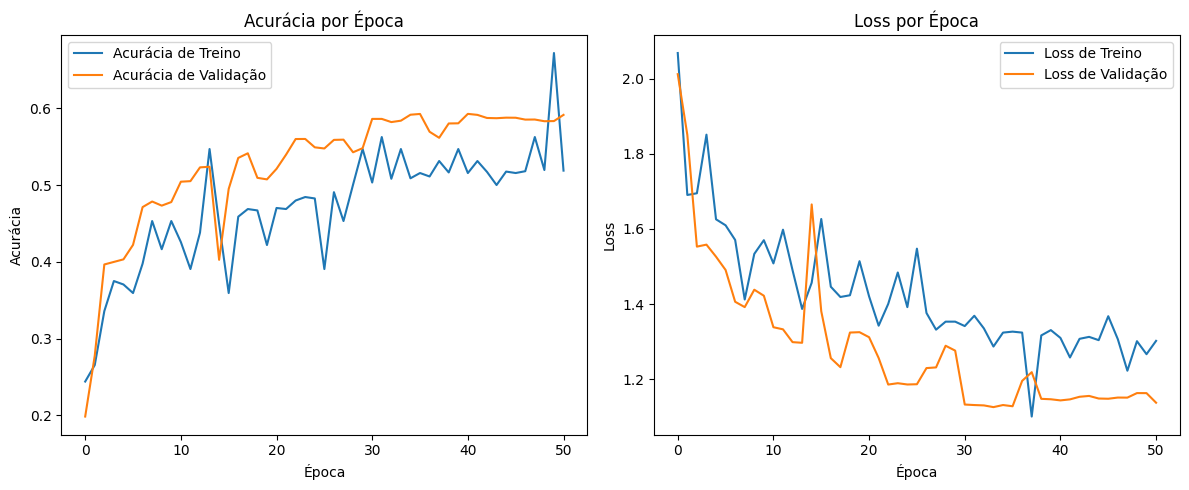

Modelo salvo em: emotion_model.keras
Sumário de treinamento salvo em: training_summary.json


In [ ]:
# Célula 10: Avaliar e salvar os resultados do treinamento
import json
import pandas as pd
import matplotlib.pyplot as plt

# 1. Visualizar as curvas de treinamento
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(12, 5))

# Gráfico de Acurácia
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Acurácia de Treino')
plt.plot(history_df['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

# Gráfico de Loss
plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Loss de Treino')
plt.plot(history_df['val_loss'], label='Loss de Validação')
plt.title('Loss por Época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# 2. Salvar o modelo treinado
model_filename = 'emotion_model.keras'
model.save(model_filename)
print(f"Modelo salvo em: {model_filename}")


# 3. Criar e salvar o sumário em JSON
# Inverte o dicionário para mapear índice -> nome da emoção
class_indices_map = {v: k for k, v in train_generator.class_indices.items()}

# Encontra a melhor época
best_epoch = np.argmax(history.history['val_accuracy'])
best_val_accuracy = np.max(history.history['val_accuracy'])
best_val_loss = history.history['val_loss'][best_epoch]

training_summary = {
    "model_name": "FacialEmotionRecognition_CNN_v1",
    "saved_model_path": model_filename,
    "timestamp": pd.to_datetime('now').isoformat(),
    "training_parameters": {
        "image_size": IMG_SIZE,
        "batch_size": BATCH_SIZE,
        "total_epochs_run": len(history.history['accuracy']),
        "best_epoch": int(best_epoch + 1)
    },
    "final_metrics": {
        "best_validation_accuracy": float(best_val_accuracy),
        "validation_loss_at_best_epoch": float(best_val_loss),
        "final_training_accuracy": float(history.history['accuracy'][-1]),
        "final_training_loss": float(history.history['loss'][-1])
    },
    "class_map": class_indices_map,
    "confidence_threshold_suggestion": 0.6, # Sugestão de threshold para o front-end
    "full_training_history": {k: [float(val) for val in v] for k, v in history.history.items()} # Converte para tipos nativos de Python
}

summary_filename = 'training_summary.json'
with open(summary_filename, 'w') as f:
    json.dump(training_summary, f, indent=4)

print(f"Sumário de treinamento salvo em: {summary_filename}")